## Importing libraries and definind globals. Connecting Google Drive storage

In [ ]:
import os
import cv2
from PIL import Image
from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Original photos of our dataset was 1024*768 pixels 24 bit depth. To save space on Google Drive we''ve croped square of 598*598 pixels and reduced dimenceonality by factor of 2. MobileNet model requires images 224*224 pixels for input. Quality of image will be reduced automaticly while reading from storrage.

In [ ]:
# 1. Define Globals: Input Shape
PATH = "/content/drive/MyDrive/final_project/"
PATH_DS = "/content/drive/MyDrive/final_project/dataset_reduced/" #cely dataset 27034 foto
PATH_MODEL = "/content/drive/MyDrive/final_project/model_mobilenet_reduced.keras"
# We will resize cropped images to a standard size, 224x224 pixels
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3 # RGB images
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
NUM_CLASSES = 4 # Example: For 4 wood quality categories
BATCH_SIZE = 32
BASE_IMAGE_DIR = ""

## Preparing Data.

In this part we create a table with filepaths of our photos.
Files for each wood quality are contained in folders with respective names, so our tabele contains a column for wood quality name.
We need to control, if each file has its pair file. For example file 0001_V.jpg should have its pair 0001_H.jpg, otherwise it shouldn't get to the final table.

So final table will contain 3 columns: filepath fot "V" image, filepath for "H" image and wood quality class for them

In [ ]:
#filepaths table. Tabulka ve formatu image_1, image_2, kvalita
def map_images_labels(path_ds):
  table = []

#projdeme vsichi vlozky naseho datasetu, nacteme odkazy na vsechne soubory do tabulky
  for quality in sorted(os.listdir(path_ds)):
    photos = sorted(os.listdir(path_ds + quality))
    for photo in range(0, len(photos)-1):

      table.append((path_ds + quality + '/' + photos[photo], quality))
  table = pd.DataFrame(table, columns=['image_1', 'quality'])

#kazdy odkaz na obrazek rozd'elime na "cesta + cislo kmenu" a "poloha na fotce"
  table["trunk_index"] = table["image_1"].apply(lambda x: "_".join(x.split("_")[0:-1]))
  table["smer"] = table["image_1"].apply(lambda x: x.split("_")[-1])
  table = pd.merge(table, table["trunk_index"].value_counts(), left_on="trunk_index", right_index=True)

#kazdy kmen mel by byt vyfoceny ve dvou polohach -> "cesta + cislo kmenu" musi se objevit dvakrat
#vyfiltrujeme neparne fotky
  table = table[table["count"] == 2]


#rozdelime fotky do dvou tabulek na H a V polohy
  image_pairs = table[table["smer"] == "H.jpg"].copy()
  verticals = table[table["smer"] == "V.jpg"].copy()

#spojime dve tabulky dle cisla kmenu
  image_pairs = pd.merge(image_pairs, verticals[["trunk_index", "image_1"]], on="trunk_index", suffixes=('_H', '_V'))
  image_pairs.rename(columns={"image_1_H": "image_1", "image_1_V": "image_2"}, inplace=True)

#zmenime oznaceni tridy qvality z pismenek na cisla
  label_map = {'AB': 0, 'C': 1, 'D': 2, 'F': 3}
  image_pairs['quality_label'] = image_pairs['quality'].map(label_map)

#vymazeme pomocne sloupci
  image_pairs.drop("trunk_index", axis=1, inplace=True)
  image_pairs.drop("smer", axis=1, inplace=True)
  image_pairs.drop("count", axis=1, inplace=True)
  image_pairs.drop("quality", axis=1, inplace=True)
  return image_pairs


In [ ]:
image_pairs = map_images_labels(PATH_DS)

In [ ]:
image_pairs.shape

(13510, 3)

In [ ]:
train, test_df = train_test_split(image_pairs, test_size=0.05, random_state=42, stratify=image_pairs["quality_label"])
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train["quality_label"])
train_df.shape, val_df.shape, test_df.shape

((10267, 3), (2567, 3), (676, 3))

In [ ]:
test_df.head(100)

,image_1,image_2,quality_label
12014,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,3
804,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,0
5148,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,1
9178,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,2
6270,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,1
...,...,...,...
8642,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,2
1734,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,0
3763,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,0
7516,/content/drive/MyDrive/final_project/dataset_r...,/content/drive/MyDrive/final_project/dataset_r...,1


## Create a Preprocessing Function for tf.data.Dataset.map()
This function will handle loading, decoding, resizing, normalization, and augmentation.

## Datovy typ "generator"

In [ ]:
def dual_input_image_generator(dataframe, base_image_dir, img_height, img_width, num_classes, batch_size, augment=False, shuffle=False):
    """
    Generates batches of paired images and labels for a dual-input Keras model.

    Args:
        dataframe (pd.DataFrame): DataFrame containing 'path_vertical', 'path_horizontal', and 'quality_label'.
        base_image_dir (str): Base directory where images are stored.
        img_height (int): Target height for image resizing.
        img_width (int): Target width for image resizing.
        num_classes (int): Number of classification categories.
        batch_size (int): Number of samples per batch.
        augment (bool): Whether to apply basic data augmentation.
    """
    num_samples = len(dataframe)
    indices = np.arange(num_samples)

    if augment:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
        )
    else:
        datagen = None

    while True:
        if shuffle:
            np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]

            batch_images_A = []
            batch_images_B = []
            batch_labels = []

            for j in batch_indices:
                row = dataframe.iloc[j]
                img_A_path = row['image_1']
                img_B_path = row['image_2']
                label = row['quality_label']

                img_A = cv2.imread(img_A_path)
                img_B = cv2.imread(img_B_path)

                if img_A is None or img_B is None:
                    continue

                img_A = cv2.resize(img_A, (img_width, img_height))
                img_B = cv2.resize(img_B, (img_width, img_height))

                img_A = cv2.cvtColor(img_A, cv2.COLOR_BGR2RGB)
                img_B = cv2.cvtColor(img_B, cv2.COLOR_BGR2RGB)

                # Normalize pixel values to [0, 1] for CNNs
                img_A = preprocess_input(img_A)
                img_B = preprocess_input(img_B)

                # Apply augmentation (if enabled)
                if datagen:
                    # Get random transform parameters for a single image
                    params = datagen.get_random_transform(img_A.shape)
                    # Apply the same random transformation to both images
                    img_A = datagen.apply_transform(img_A, params)
                    img_B = datagen.apply_transform(img_B, params)


                batch_images_A.append(img_A)
                batch_images_B.append(img_B)
                batch_labels.append(label)

            if len(batch_labels) > 0:
                batch_images_A = np.array(batch_images_A, dtype=np.float32)
                batch_images_B = np.array(batch_images_B, dtype=np.float32)
                batch_labels_one_hot = to_categorical(np.array(batch_labels), num_classes=num_classes)

                yield ({'input_image_A': batch_images_A, 'input_image_B': batch_images_B}, batch_labels_one_hot)

In [ ]:
# Define the output signature for the generator
# The generator yields a tuple: (input_dict, labels_array)
# input_dict has keys 'input_image_A' and 'input_image_B' with image tensors
# labels_array is the one-hot encoded labels tensor
output_signature = (
    {
        'input_image_A': tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=tf.float32),
        'input_image_B': tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=tf.float32)
    },
    tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32) # Labels are one-hot encoded
)

# Create tf.data.Dataset from the generators
train_dataset = tf.data.Dataset.from_generator(
    lambda: dual_input_image_generator(train_df, BASE_IMAGE_DIR, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, BATCH_SIZE, augment=True, shuffle=True),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dual_input_image_generator(val_df, BASE_IMAGE_DIR, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, BATCH_SIZE, augment=False),
    output_signature=output_signature
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: dual_input_image_generator(test_df, BASE_IMAGE_DIR, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, BATCH_SIZE, augment=False),
    output_signature=output_signature
)
# Define steps per epoch based on the dataset size and batch size
# Use // to ensure integer division
steps_per_epoch_train = len(train_df) // BATCH_SIZE
steps_per_epoch_val = len(val_df) // BATCH_SIZE
steps_per_epoch_test = len(test_df) // BATCH_SIZE

print(f"\nSteps per epoch (Train): {steps_per_epoch_train}")
print(f"Steps per epoch (Validation): {steps_per_epoch_val}")
print(f"Steps per epoch (Test): {steps_per_epoch_test}")


Steps per epoch (Train): 320
Steps per epoch (Validation): 80
Steps per epoch (Test): 21


# Vytvoření modelu

In [ ]:
# 2. Create the Base CNN Model (e.g., InceptionV3)
# We will use the convolutional base of InceptionV3, excluding the top classification layer.
# Freeze the layers of the base model to use it as a feature extractor.
def create_base_cnn(input_shape):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False # Freeze the layers
    return base_model

# 3. Define the Two Input Branches
# We will create two separate Input layers and connect them to our base CNN.

# Input for the first image of the trunk (e.g., Photo A)
input_a = keras.Input(shape=INPUT_SHAPE, name='input_image_A')
# Input for the second image of the trunk (e.g., Photo B)
input_b = keras.Input(shape=INPUT_SHAPE, name='input_image_B')

# Instantiate the base CNN model. Keras will share the weights if you call the same model instance twice.
# This means both branches use the same learned features.
base_cnn_model = create_base_cnn(INPUT_SHAPE)

# Process each input through the base CNN
features_a = base_cnn_model(input_a)
features_b = base_cnn_model(input_b)

# 4. Add Pooling/Flattening to Feature Maps
# After the convolutional base, we need to flatten the feature maps into a 1D vector.
# GlobalAveragePooling2D is often preferred over Flatten as it reduces parameters and overfitting.
pooled_features_a = layers.GlobalAveragePooling2D()(features_a)
pooled_features_b = layers.GlobalAveragePooling2D()(features_b)

# 5. Concatenate the Features
# Combine the feature vectors from both branches.
# The 'axis=-1' means concatenate along the last dimension (the feature dimension).
concatenated_features = layers.concatenate([pooled_features_a, pooled_features_b], axis=-1)

# 6. Add the Classification Head
# These are new Dense layers that will learn to classify based on the combined features.
x = layers.Dense(256, activation='relu')(concatenated_features)
x = layers.Dropout(0.2)(x) # Dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax', name='output_quality_prediction')(x)

# 7. Create the Keras Model
# Define the model with two inputs and one output.
model = keras.Model(inputs=[input_a, input_b], outputs=output)

# 8. Compile the Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), # Changed optimizer to Adam
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_A       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_image_B       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_224  │ (None, 7, 7,      │  3,228,864 │ input_image_A[0]… │
│ (Functional)        │ 1024)             │            │ input_image_B[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ mobilenet_1.00_2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ mobilenet_1.00_2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2048)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_quality_pre… │ (None, 4)         │        516 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,786,820 (14.45 MB)

 Trainable params: 557,956 (2.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

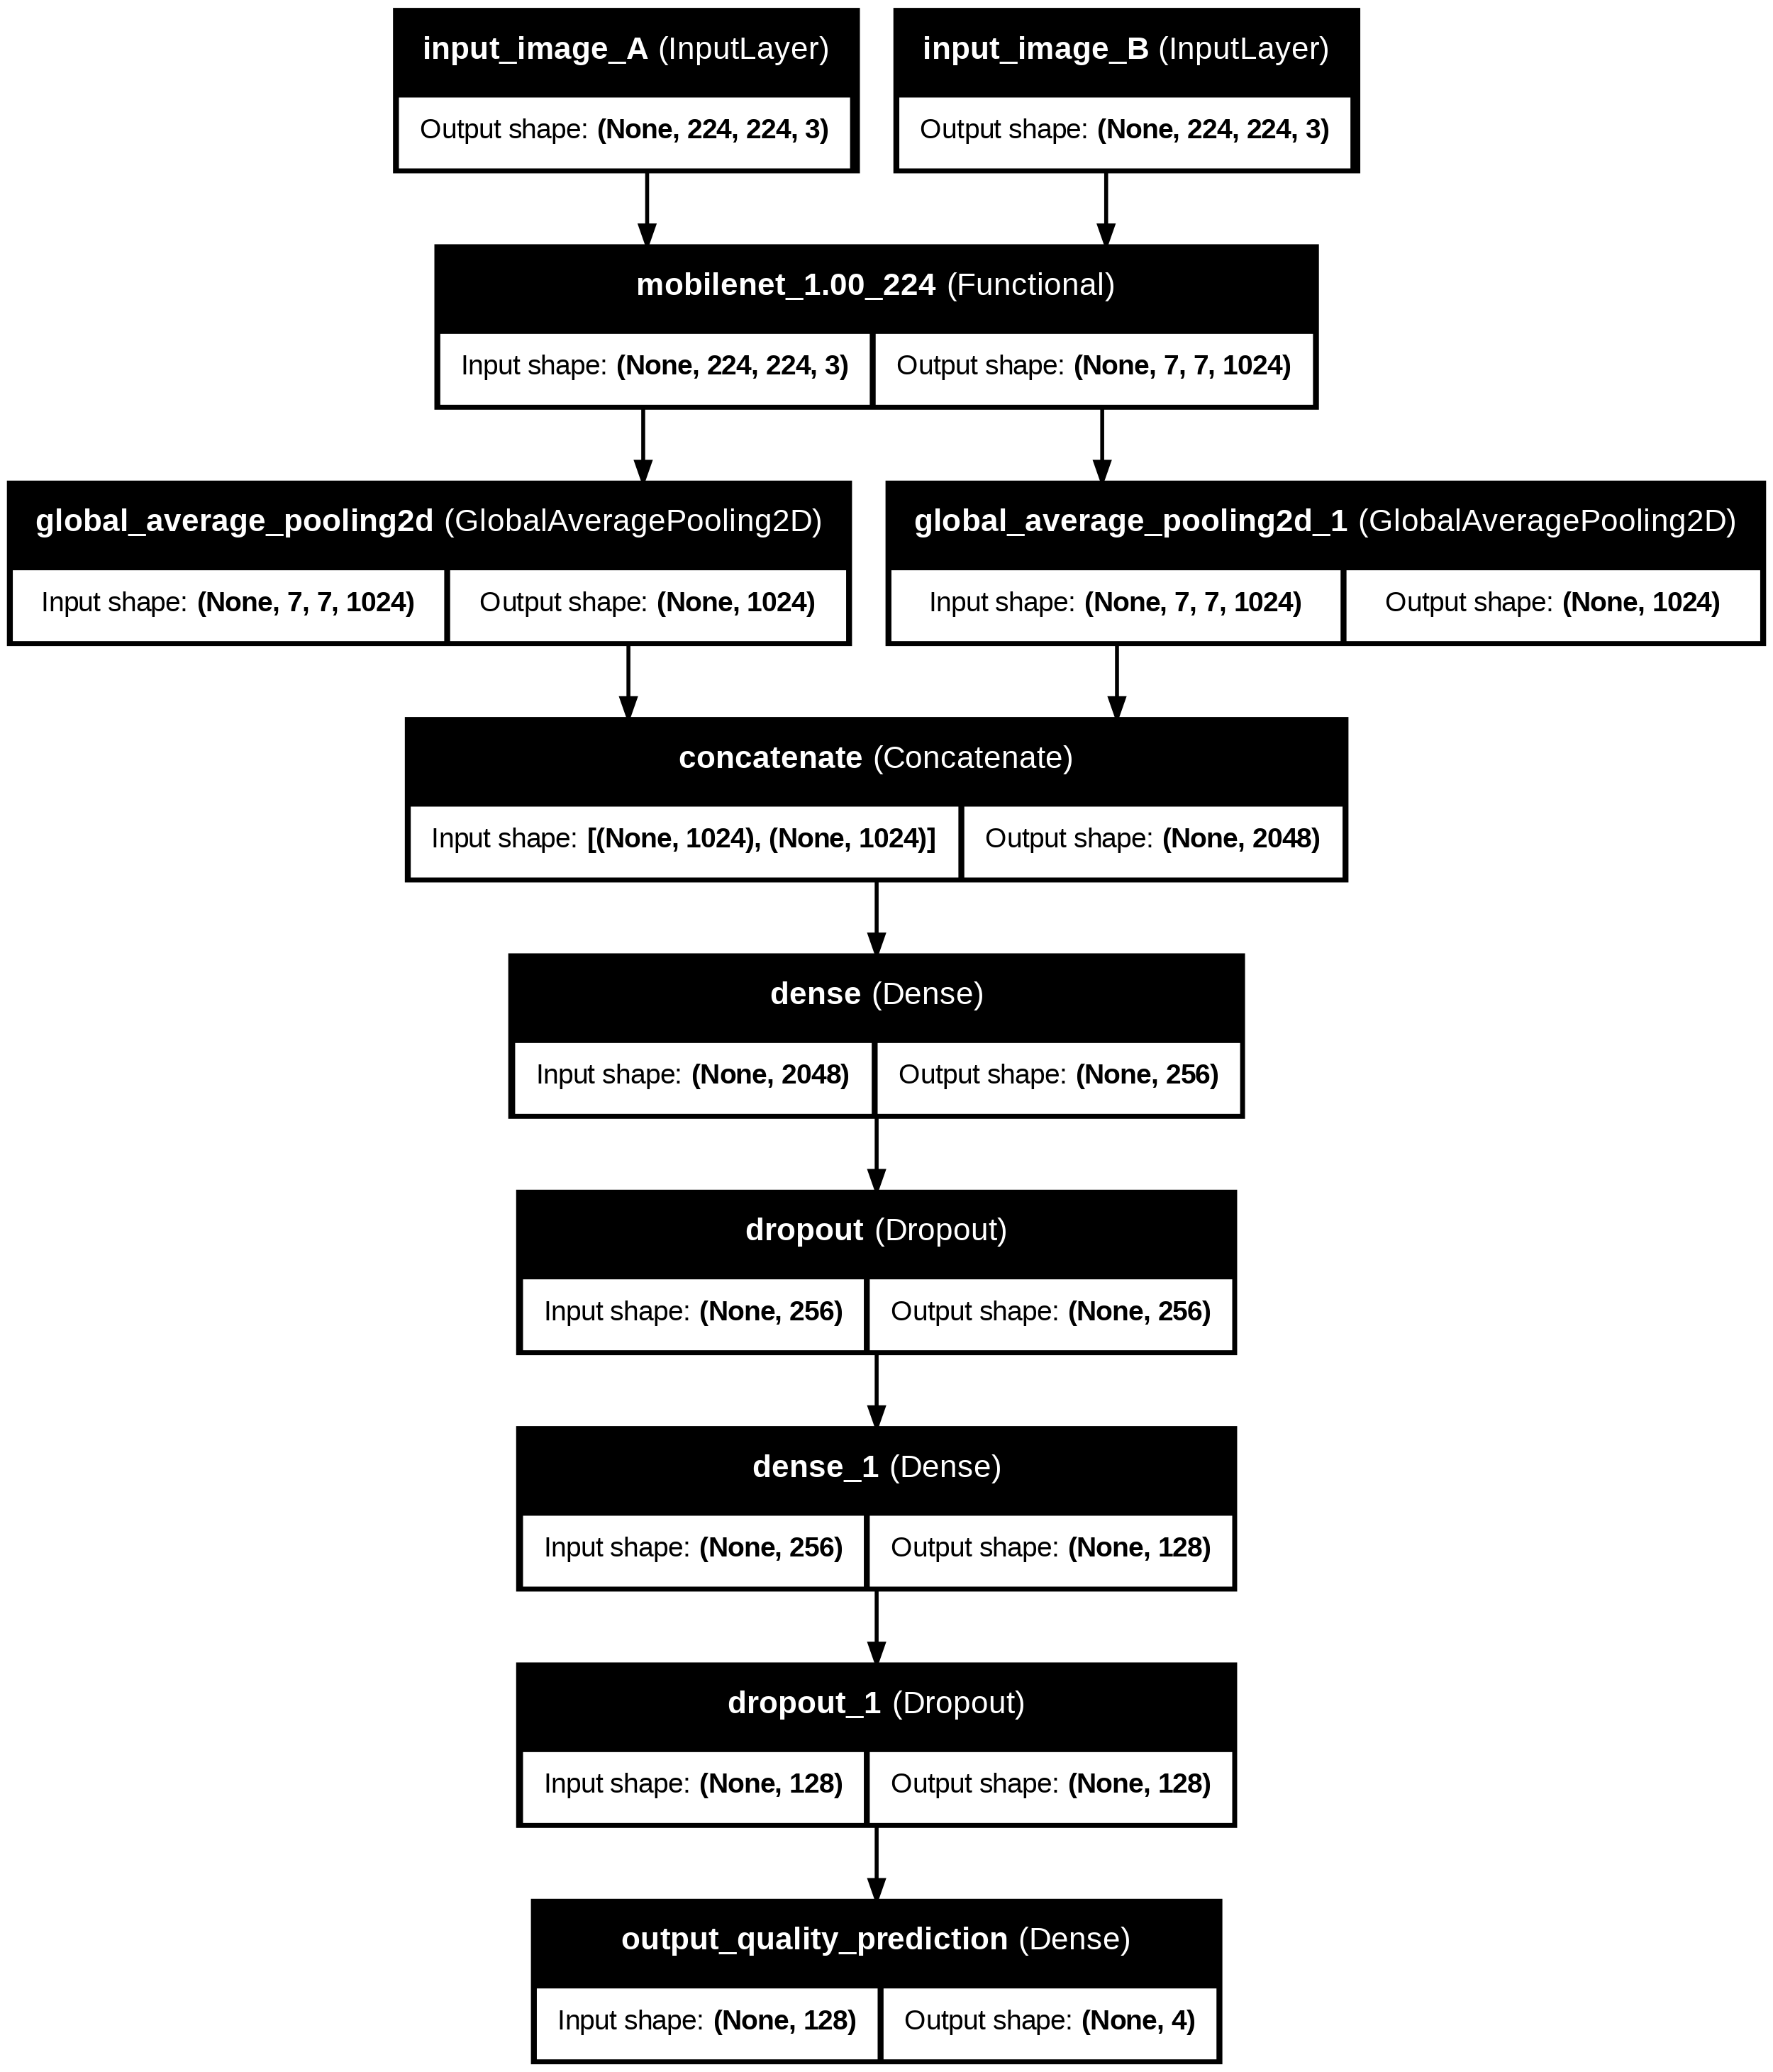

In [ ]:
# Visualize the model (requires graphviz and pydot to be installed)
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Trenovani modelu

In [ ]:
model = tf.keras.models.load_model(PATH + 'model_mobilenet_reduced.keras')

In [ ]:
early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0.003,
                      patience=7,
                      restore_best_weights=True)

saving = ModelCheckpoint(PATH_MODEL,
                         monitor='val_accuracy',
                         save_best_only=True,
                         initial_value_threshold=0.4
                         )
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',
                                 factor=0.75,
                                 patience=5,
                                 min_lr=1e-6)

In [ ]:
# Example of how you'd fit your model (assuming your model is already built as per previous advice)
history = model.fit(
     train_dataset, # Use the tf.data.Dataset
     steps_per_epoch=steps_per_epoch_train,
     epochs=50, # Or more
     validation_data=val_dataset, # Use the tf.data.Dataset
     validation_steps=steps_per_epoch_val,
     callbacks=[early, saving, lr_scheduler]
    )

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 22774s 71s/step - accuracy: 0.6203 - loss: 0.8684 - val_accuracy: 0.6102 - val_loss: 0.9071 - learning_rate: 0.0010
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.6212 - loss: 0.8530 - val_accuracy: 0.6027 - val_loss: 0.9253 - learning_rate: 0.0010
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.6118 - loss: 0.8689 - val_accuracy: 0.6070 - val_loss: 0.9254 - learning_rate: 0.0010
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.6220 - loss: 0.8416 - val_accuracy: 0.6070 - val_loss: 0.9159 - learning_rate: 0.0010
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.6172 - loss: 0.8607 - val_accuracy: 0.6023 - val_loss: 0.9017 - learning_rate: 0.0010
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.6255 - loss: 0.8415 - val_accuracy: 0.6121 - val_loss: 0.9300 - learning_rate: 0.0010
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.6310 - loss:

In [ ]:
model.save(PATH + 'model_mobilenet_reduced_reserve.keras')

# Visualisace jak se model trenoval

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')

plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.xlabel('Epoch Number')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Hodnoceni efektyvity modelu

In [ ]:
small_test_dataset = test_dataset.take(steps_per_epoch_test)

In [ ]:
y_pred = model.predict(small_test_dataset)

21/21 ━━━━━━━━━━━━━━━━━━━━ 586s 28s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
y_pred

array([[2.4163404e-01, 4.3410924e-01, 2.9759353e-01, 2.6663205e-02],
       [6.5486974e-01, 1.5559982e-01, 1.8933557e-01, 1.9487523e-04],
       [5.4038173e-01, 2.0277371e-01, 2.5421935e-01, 2.6252270e-03],
       ...,
       [1.4963276e-10, 8.4203604e-09, 7.8457800e-09, 1.0000000e+00],
       [6.4294410e-01, 2.4543327e-01, 1.0606463e-01, 5.5580409e-03],
       [5.0236857e-01, 2.0944124e-01, 2.8355983e-01, 4.6304017e-03]],
      dtype=float32)

In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
# To access elements from a TensorFlow dataset, you need to iterate over it.
# We can convert it to a NumPy iterator and take the elements one by one.
y_test = [] # Initialize as a list
for elements in small_test_dataset.as_numpy_iterator():
  y_test.append(np.argmax(elements[1], axis=1)) # Use the append method of the y_test list

# If needed, convert the list of arrays to a single NumPy array after the loop
y_test = np.concatenate(y_test)

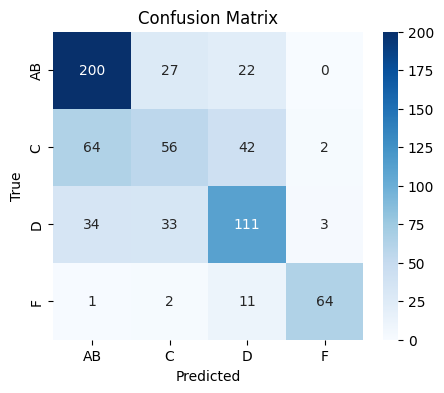

In [ ]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AB', 'C', 'D', 'F'], yticklabels=['AB', 'C', 'D', 'F'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_test, y_pred_labels, target_names=['AB', 'C', 'D', 'F'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          AB       0.67      0.80      0.73       249
           C       0.47      0.34      0.40       164
           D       0.60      0.61      0.60       181
           F       0.93      0.82      0.87        78

    accuracy                           0.64       672
   macro avg       0.67      0.64      0.65       672
weighted avg       0.63      0.64      0.63       672

